In [24]:
import numpy as np
import random
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqUtils import nt_search
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
from ipywidgets import IntProgress
from IPython.display import display
import time
import datetime
import itertools
from statistics import mean, stdev
import rapidfuzz
import string

## Helper functions

In [21]:
def plot_comparison_threshold(rfam_file, random_file, label):
    df_rfam = pd.read_csv(rfam_file)
    df_random = pd.read_csv(random_file)
    # For smoothing the plot
    df_rfam['seq_length'] = df_rfam['seq_length'].apply(lambda x: round(x, -1))

    plt.title('SD detection')
    plt.xlabel('Length of sequence')
    plt.ylabel('Length of longest stretch')
    sns.lineplot(data=df_rfam, x='seq_length', y='length', label=label)
    sns.lineplot(data=df_random, x='seq_length', y='length', label='random sequences')
    plt.show()
    

In [22]:
def plot_list(filenames, labels, title):
    dfs = [pd.read_csv(f'results/{file}') for file in filenames]
    plt.title(title)
    plt.xlabel('Length of sequence')
    plt.ylabel('Length of longest SD stretch')
    for i, df in enumerate(dfs):
        # Smooth curve
        df['seq_length'] = df['seq_length'].apply(lambda x: round(x, -1))
        sns.lineplot(data=df, x='seq_length', y='length', label=labels[i])
    plt.show()

In [23]:
def plot_threshold(file_bases, labels):
    fig, ax = plt.subplots(1,len(file_bases))
    fig.suptitle('SD across thresholds')
    fig.supylabel('Length of longest SD stretch')
    fig.supxlabel('Sequence length')
    fig.set_size_inches(26,8)
    fig.subplots_adjust(left=0.04, wspace=0.15)
    for i, file_base in enumerate(file_bases):
        dfs = [pd.read_csv('results/' + file_base + f'_threshold_{threshold}_extra.csv') for threshold in range(6)]
        for df in dfs:
            df['seq_length'] = df['seq_length'].apply(lambda x: round(x, -1))
        source_list = list(range(11))
        df = pd.concat([df.assign(**{'threshold':source}) for df, source in zip(dfs, source_list)])

        sns.lineplot(data=df, x='seq_length', y='length', hue='threshold', ax=ax[i]).set(
            title=labels[i], xlabel=None, ylabel=None)
    

## Sequences from Lucks paper

In [8]:
# Read sequences from a fasta file into an array
def load_fasta(file):
    fasta_seqs = SeqIO.parse(open(file), 'fasta')
    seqs = [seq.seq for seq in fasta_seqs]
    return seqs
# Same as find_fuzzy but also adds a normalized hamming distance constraint on the substring
def find_fuzzy_extra(string, substring, threshold, p_distance):
    str_len = len(substring)    
    for i in range(len(string) - str_len + 1):
        sub_str = string[i:i+str_len]
        if rapidfuzz.distance.Hamming.distance(sub_str, substring) <= threshold and rapidfuzz.distance.Hamming.normalized_distance(sub_str, substring) <= p_distance: 
            return i
    return -1
def a_astar_a_threshold(dna, threshold, p_distance):
    longest_substring = ""
    longest_length = 0
    
    for i in range(len(dna)):
        for j in range(i, len(dna)):
            # Extract the substring
            substring = dna[i:j+1]
            reverse_complement = substring.reverse_complement()
            # Check if the reverse complement substring exists after the substring
            index_rev_comp = dna.find(reverse_complement, j+1)

            # Check if the substring occurs again after the reverse complement
            if index_rev_comp != -1 and find_fuzzy_extra(dna[index_rev_comp+len(reverse_complement):], substring, threshold, p_distance) != -1:
                # Update the longest substring and its length if necessary
                if j-i+1 > longest_length:
                    longest_substring = substring
                    longest_length = j-i+1
    return len(longest_substring), longest_substring
def astar_a_a_threshold(dna, threshold, p_distance):
    longest_substring = ""
    longest_length = 0
    
    for i in range(len(dna)):
        for j in range(i, len(dna)):
            # Extract the substring
            substring = dna[i:j+1]
            reverse_complement = substring.reverse_complement()
            # Check if the reverse complement substring exists after the substring
            index_rev_comp = dna.find(reverse_complement, j+1)

            # Check if the substring occurs again after the reverse complement
            
            if index_rev_comp != -1 and find_fuzzy_extra(dna[index_rev_comp+len(reverse_complement):], reverse_complement, threshold, p_distance) != -1:
                # Update the longest substring and its length if necessary
                if j-i+1 > longest_length:
                    longest_substring = substring
                    longest_length = j-i+1
    return len(longest_substring), longest_substring
def a_a_astar_threshold(dna, threshold, p_distance):
    length, seq = astar_a_a_threshold(dna[::-1],threshold,p_distance)
    return length, seq.complement()

In [9]:
def run_lucks(seqs, threshold, p_distance):
    lengths = []
    seq_lengths = []
    max_seqs = []
    
    for seq in seqs:
        seq = seq.replace('U','T')
        if not set(seq).issubset({'A','C','T','G'}):
            raise Exception('Non standard base in sequence')
        max1, seq1 = a_astar_a_threshold(seq, threshold, p_distance)
        max2, seq2 = astar_a_a_threshold(seq, threshold, p_distance)
        max3, seq3 = a_a_astar_threshold(seq, threshold, p_distance)
        
        d = {
            seq1: max1,
            seq2: max2,
            seq3: max3
        }
        
        max_len = max(max1, max2, max3)
        max_seq = max(d, key=d.get)
    
        lengths.append(max_len)
        seq_lengths.append(len(seq))
        max_seqs.append(str(max_seq))
    data = {'length':lengths, 'seq_length':seq_lengths, 'seq (My script)':max_seqs, 'invading_seq (Lucks paper)':[str(s) for s in invading_seqs]}
    df = pd.DataFrame.from_dict(data)
    return df

In [81]:
files = ['CP000721.1.fasta','LRVM01000003.1.fasta','GL834314.1[200067..200147].fa','MAPZ01000019.1[81898..81979].fa','CP006721.1[1418877..1418954].fa','CP000721.1[4111685..4111764].fa','MZGT01000008.1[8211..8289].fa','ACOM01000001.1[496623..496702].fa','HG917869.1[204603..204682].fa']
seqs = [load_fasta(f'lucks/{file}')[0] for file in files]
invading_seqs = [Seq('GCCTGGATTGCGTCGGC'),Seq('GCCGACAATCCGGGC'),Seq('GCCGGCAGTCCGGGC'),Seq('GCCGACAATCTGAGC'),Seq('GCCCAGACAGTCGGC'),Seq('GTCCAGATAGTGGGC'),Seq('GCCCACTGTCCGGAC'),Seq('GTCCGGATAGGTGGGC'),Seq('GTCCAGATGGTGGGC')]

In [114]:
threshold = 5
p_distance = 0.5
run_lucks(seqs, threshold, p_distance)

,length,seq_length,seq (My script),invading_seq (Lucks paper)
0,8,99,TAGTCATA,GCCTGGATTGCGTCGGC
1,7,84,GATTATA,GCCGACAATCCGGGC
2,7,81,GATCATA,GCCGGCAGTCCGGGC
3,7,82,AGTCATA,GCCGACAATCTGAGC
4,8,78,TAGTCATA,GCCCAGACAGTCGGC
5,7,80,GTTATAC,GTCCAGATAGTGGGC
6,7,79,GTTATAC,GCCCACTGTCCGGAC
7,7,80,GTTATAC,GTCCGGATAGGTGGGC
8,6,80,GTTATA,GTCCAGATGGTGGGC


## SD Finder results

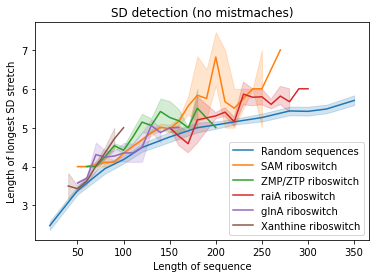

In [18]:
codes = ['random','RF00162','RF01750','RF03072','RF01739','RF03054']
filenames = [code+'_threshold_0_extra.csv' for code in codes]
labels = ['Random sequences','SAM riboswitch','ZMP/ZTP riboswitch','raiA riboswitch','glnA riboswitch','Xanthine riboswitch']
title = 'SD detection (no mistmaches)'
plot_list(filenames, labels, title)


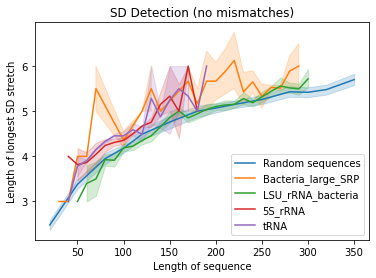

In [96]:
filenames = ['random_threshold_0_extra.csv','RF01854_threshold_0_extra.csv','RF02541_threshold_0_extra.csv','RF00001_threshold_0_extra.csv','RF00005_threshold_0_extra.csv']
labels = ['Random sequences','Bacteria_large_SRP','LSU_rRNA_bacteria','5S_rRNA','tRNA']
title = 'SD Detection (no mismatches)'
plot_list(filenames, labels, title)


In [ ]:
# TODO
# think about allowing bulges
# next step is scanning bacterial genome in windows


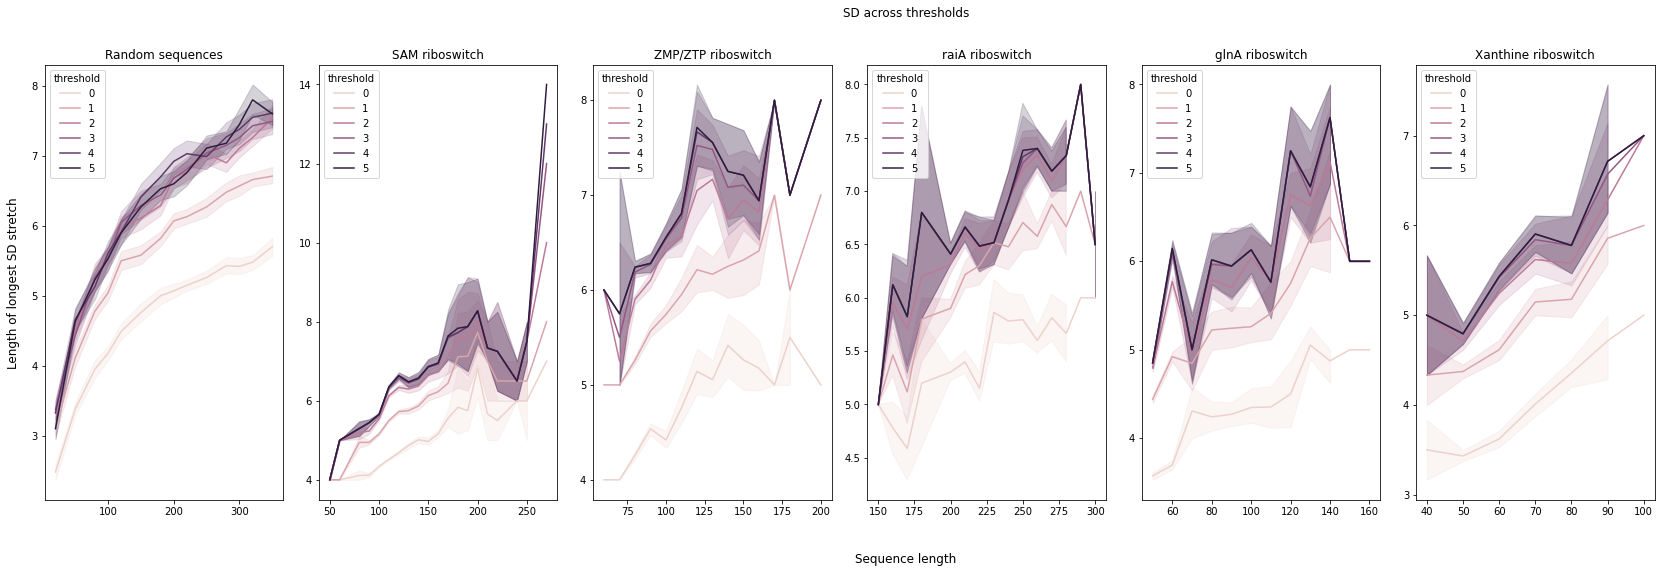

In [19]:
file_bases = ['random','RF00162','RF01750','RF03072','RF01739','RF03054']
labels = ['Random sequences','SAM riboswitch','ZMP/ZTP riboswitch','raiA riboswitch','glnA riboswitch','Xanthine riboswitch']
plot_threshold(file_bases, labels)


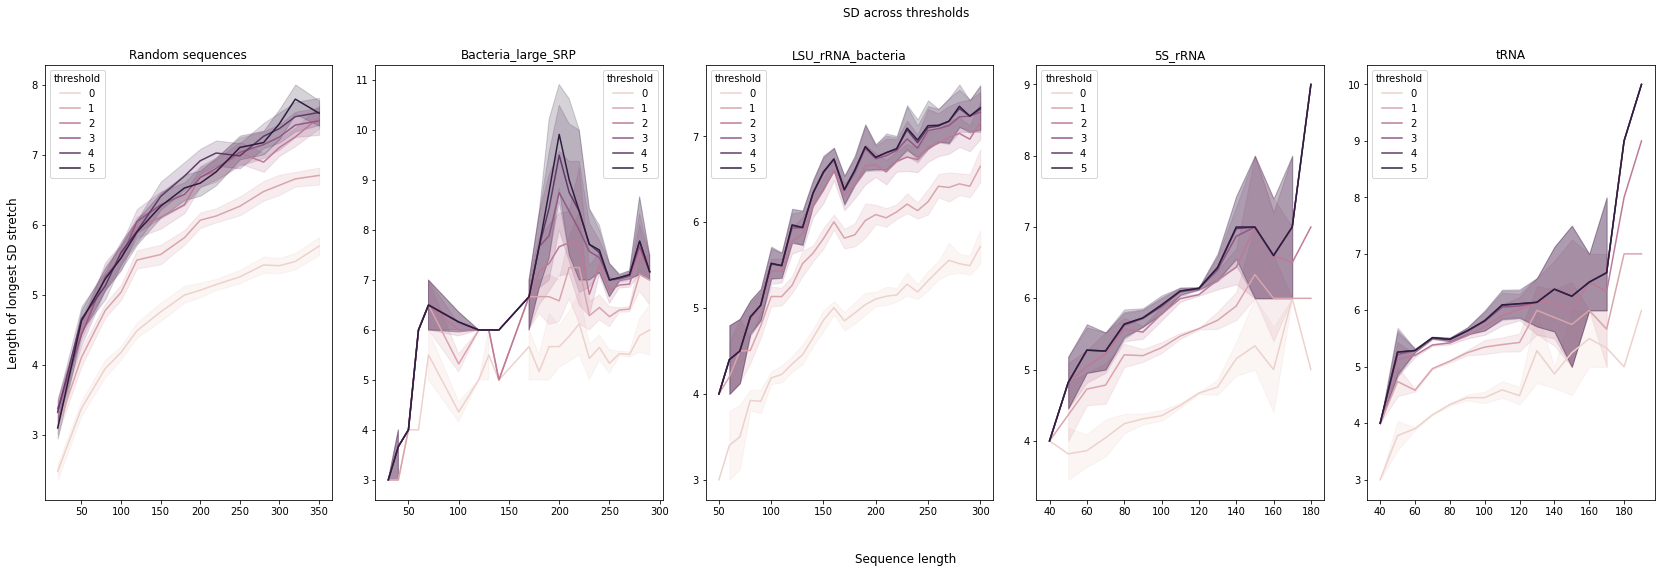

In [104]:
file_bases = ['random','RF01854','RF02541','RF00001','RF00005']
labels = ['Random sequences','Bacteria_large_SRP','LSU_rRNA_bacteria','5S_rRNA','tRNA']
plot_threshold(file_bases, labels)


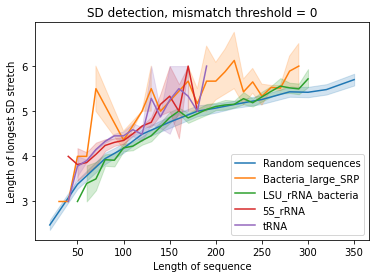

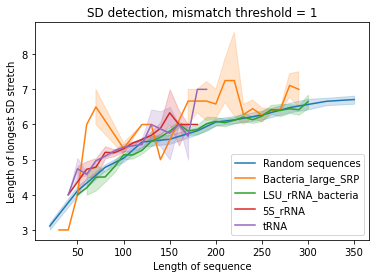

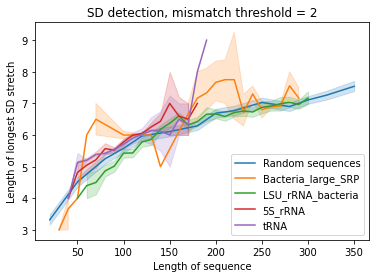

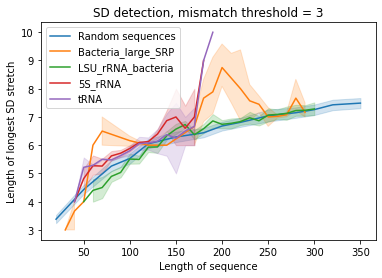

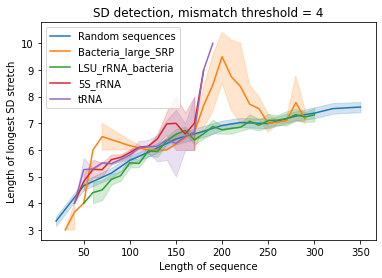

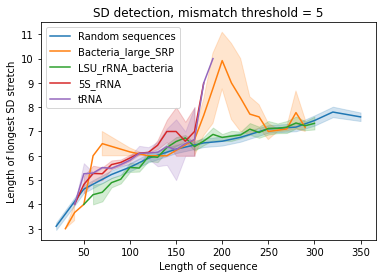

In [106]:
for threshold in range(6):
    filenames = [f'random_threshold_{threshold}_extra.csv',f'RF01854_threshold_{threshold}_extra.csv',f'RF02541_threshold_{threshold}_extra.csv',f'RF00001_threshold_{threshold}_extra.csv',f'RF00005_threshold_{threshold}_extra.csv']
    labels = ['Random sequences','Bacteria_large_SRP','LSU_rRNA_bacteria','5S_rRNA','tRNA']
    title = 'SD detection, mismatch threshold = ' + str(threshold)
    plot_list(filenames, labels, title)


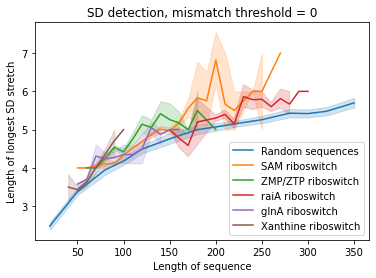

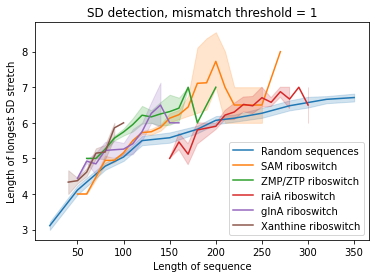

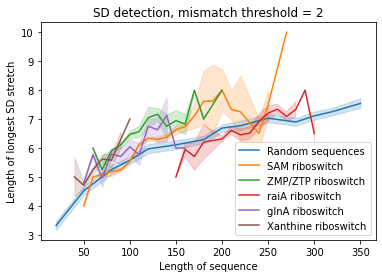

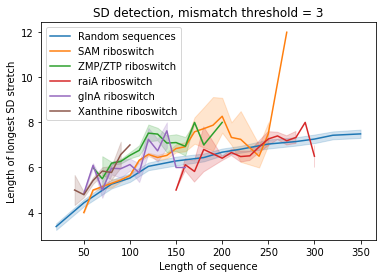

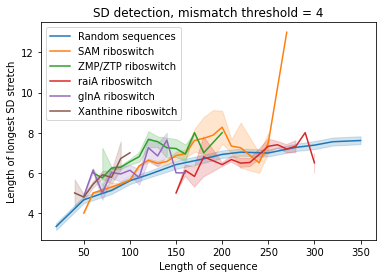

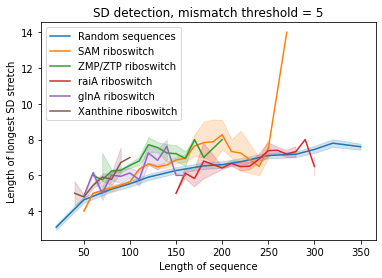

In [ ]:
for threshold in range(11):
    filenames = [f'random_threshold_{threshold}_extra.csv',f'RF00162_threshold_{threshold}_extra.csv',f'RF01750_threshold_{threshold}_extra.csv',f'RF01852_threshold_{threshold}_extra.csv']
    labels = ['Random sequences','SAM riboswitch','ZMP/ZTP riboswitch','tRNA-Sec']
    title = 'SD detection, mismatch threshold = ' + str(threshold)
    plot_list(filenames, labels, title)
